In [4]:
from IPython.display import clear_output
%pip install matplotlib
%pip install requests
%pip install Basemap
%pip install pyodbc
%pip install numpy
#%matplotlib qt
clear_output()

In [1]:
from mpl_toolkits.basemap import Basemap
from io import BytesIO, StringIO
from tqdm import tqdm
import matplotlib.pyplot as plt
import tifffile as tiff
import pandas as pd
import numpy as np
import requests
import pyodbc

In [46]:
path = "data_VDL.tif"
tif_image = tiff.imread(path)


In [96]:
def geo_to_pixel(longitude, latitude, image_shape):
    """
    Convert geographical coordinates to pixel indices.
    """
    # Image shape
    num_lat_pixels, num_long_pixels, _ = image_shape
    
    # Convert longitude and latitude to pixel indices
    x = int((longitude + 180) * (num_long_pixels - 1) / 360.0)
    y = int((-latitude + 90) * (num_lat_pixels - 1) / 180.0)

    return x, y

def get_subarray(image, up_left_corner, low_right_corner):
    """
    Extract a subarray from the image based on geographical coordinates.
    """
    # Convert geo-coordinates to pixel indices
    ul_x, ul_y = geo_to_pixel(*up_left_corner, image.shape)
    lr_x, lr_y = geo_to_pixel(*low_right_corner, image.shape)
    # Extract the subarray
    subarray = image[ul_y:lr_y, ul_x:lr_x, :]
    
    return subarray

# Example usage
""" Floride
up_left_corner = (-87, 31)  # Upper left corner coordinates lon, lat
low_right_corner= (-79, 24) # Lower right corner coordinates
"""
ulc_USA = (-125, 49)  # Upper left corner coordinates lon, lat
lrc_USA = (-66, 23) # Lower right corner coordinates

ulc_FRA = (-4, 50)  # Upper left corner coordinates lon, lat
lrc_FRA = (7, 42) # Lower right corner coordinates

image_USA = get_subarray(tif_image, ulc_USA, lrc_USA)
mask = np.all(image_USA == [65535, 65535, 65535], axis=-1)
image_USA[mask] = [0, 0, 0]

image_FRA = get_subarray(tif_image, ulc_FRA, lrc_FRA)
mask = np.all(image_FRA == [65535, 65535, 65535], axis=-1)
image_FRA[mask] = [0, 0, 0]

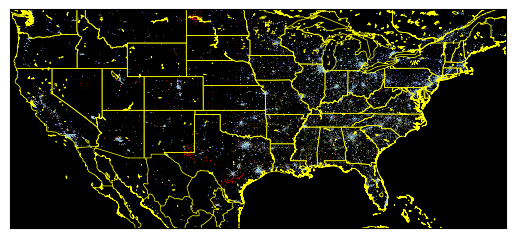

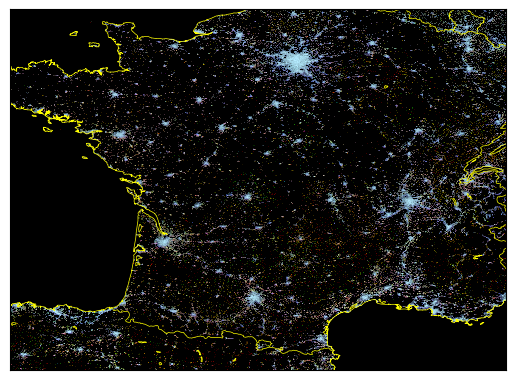

In [97]:
plt.figure()
m = Basemap(projection='cyl',
            llcrnrlat=lrc_USA[1], urcrnrlat=ulc_USA[1],
            llcrnrlon=ulc_USA[0], urcrnrlon=lrc_USA[0],
            resolution="h")
m.drawcountries(color="yellow",linewidth=0.5)
m.drawstates(color="yellow",linewidth=0.5)
m.drawcoastlines(color="yellow",linewidth=0.5)
plt.imshow(image_USA, interpolation='none', extent=(ulc_USA[0],lrc_USA[0],lrc_USA[1],ulc_USA[1]))
plt.show()

plt.figure()
m = Basemap(projection='cyl',
            llcrnrlat=lrc_FRA[1], urcrnrlat=ulc_FRA[1],
            llcrnrlon=ulc_FRA[0], urcrnrlon=lrc_FRA[0],
            resolution="h")
m.drawcountries(color="yellow",linewidth=0.5)
m.drawstates(color="yellow",linewidth=0.5)
m.drawcoastlines(color="yellow",linewidth=0.5)
plt.imshow(image_FRA, interpolation='none', extent=(ulc_FRA[0],lrc_FRA[0],lrc_FRA[1],ulc_FRA[1]))
plt.show()

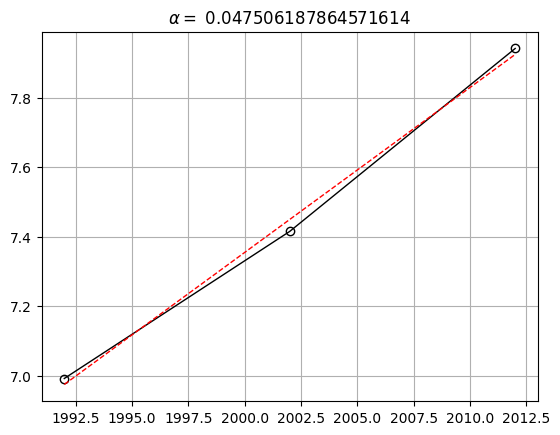

In [103]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x + b

years = [1992,2002,2012]
mean_luminosity_USA = [np.mean(image_USA[:,:,0]), np.mean(image_USA[:,:,1]), np.mean(image_USA[:,:,2])]
mean_luminosity_FRA = [np.mean(image_FRA[:,:,0]), np.mean(image_FRA[:,:,1]), np.mean(image_FRA[:,:,2])]

year_opt = np.linspace(years[0],years[2])
popt_USA, pcov = curve_fit(func, years, mean_luminosity_USA)
popt_FRA, pcov = curve_fit(func, years, mean_luminosity_FRA)

plt.figure()
plt.plot(years,mean_luminosity_USA, color="black", marker="o", fillstyle='none', linewidth=1)
plt.plot(years,mean_luminosity_FRA, color="black", marker="o", fillstyle='none', linewidth=1)
plt.plot(year_opt, func(year_opt, *popt), color='red', linestyle="--", linewidth=1)
plt.title(fr"$\alpha =$ {popt[0]}")
plt.grid()
plt.show()

In [46]:
mdb_file_path = 'C:\\Users\\test\\Documents\\Codes\\Python\\Personnel\\NASA-hackathon-2024\\data_SEDAC.mdb'
conn_str = r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ='+mdb_file_path+';'

try:
    conn = pyodbc.connect(conn_str)
    query = "SELECT TOP 365 * FROM [Sustainability Indicators Metadata]"
    data_bibli = pd.read_sql(query, conn)
    conn.close()

except pyodbc.Error as e:
    print("Error:", e)

C:\Users\test\AppData\Local\Temp\ipykernel_14796\2992570609.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_bibli = pd.read_sql(query, conn)


In [68]:
index  = pd.Index(data_bibli["Variable"]).get_loc('GDP90')
print(data_bibli.iloc[index])

Collection                                                 Ancillary Data
Variable                                                            GDP90
Variable #                                                            446
Sub-Index                                                            None
Variable Description                               GDP in 2000 US Dollars
Units                          Millions of US Dollars (constant 2000 US$)
Reference Year                                                       1990
Source                  World Bank Development Data Group. 2006. World...
Methodology             Gross domestic product (GDP) measures the tota...
Full Description                                                     None
Rationale                                                            None
Name: 31, dtype: object


In [33]:
data_SEDAC = pd.read_csv("data_SEDAC.csv", sep=",", encoding="latin1")
data_SEDAC_GDP92 = data_SEDAC["GDP92"].to_numpy()
data_SEDAC_GDP92[data_SEDAC_GDP92 == ' '] = np.nan

In [34]:
data_Country = data_SEDAC["Country_Standard"].to_list()
data_GDP = []
for gpd_int in np.linspace(1992,2004,13,dtype=int).astype(str):
    inter = data_SEDAC[f"GDP{gpd_int[2:]}"].to_numpy()
    inter[inter == ' '] = 0.0
    data_GDP.append(inter.astype(float))

df = pd.DataFrame(data_GDP, columns=data_Country, index=np.linspace(1992,2004,13,dtype=int))

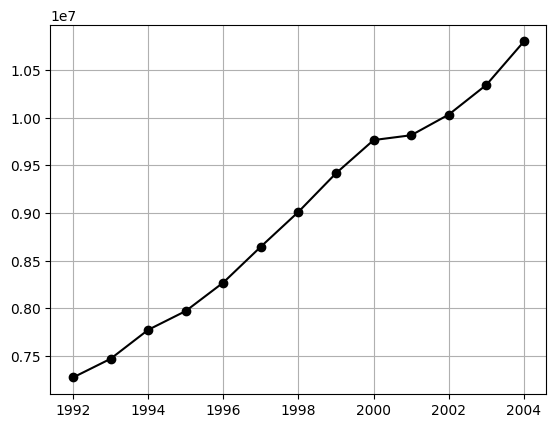

In [75]:
plt.figure()
plt.plot(df.index.values,df["United States of America"].to_numpy(), color="black", marker="o")
plt.grid()
plt.show()